In [1]:
%%capture
!pip install pafy youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy
!pip install imageio-ffmpeg

In [2]:
!pip install imageio


In [3]:
!pip install google

In [5]:
# Import the required libraries.
import os

# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

In [8]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [10]:
!pip install opencv-python

In [11]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (50,50 ))

# Get the names of all classes in dataset
all_classes_names = os.listdir('dataset')
print(all_classes_names)

random_range = random.sample(range(len(all_classes_names)), 2)
print(random_range)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
    print(selected_class_Name)

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'dataset/{selected_class_Name}')
    print(video_files_names_list)

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    print(selected_video_file_name)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'dataset/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    # rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

['accidents', 'normals']
[0, 1]
accidents
['13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_2809_3017.mp4', '1_70mph Pile Up_130_524.mp4', '1_70mph Pile Up_1508_1588.mp4', '1_70mph Pile Up_1782_1898.mp4', '1_70mph Pile Up_2087_2519.mp4', '2013 Severe winter weather causes multi-vehicle crash on Highway 4145 at Lannon Rd in Germantown_7566_8016.mp4', '2020s Worst Red-Light Runners_1013_1130.mp4', '2020s Worst Red-Light Runners_422_557.mp4', '2020s Worst Red-Light Runners_728_848.mp4', '2020s Worst Red-Light Runners_885_971.mp4']
1_70mph Pile Up_130_524.mp4


NameError: name 'cv2' is not defined

<Figure size 5000x5000 with 0 Axes>

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/drive/MyDrive/MobileVnet2 Dataset/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Violence", "NonViolence"]
# /content/drive/MyDrive/MobileVnet2 Dataset/NonViolence

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total Frame in video count", video_frames_count)

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    print("skip_frames_window", skip_frames_window)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # print(frame_counter)

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        zoom = iaa.Affine(scale=1.3)
        random_brightness = iaa.Multiply((1, 1.3))
        #rotate = iaa.Affine(rotate=(-25, 25))

        #image_aug = flip(image = image)
        image_aug = random_brightness(image = frame)
        image_aug = zoom(image = image_aug)
        #image_aug = rotate(image = image_aug)



        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(image_aug, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # cv2_imshow(resized_frame)

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
# data = frames_extraction("/content/drive/MyDrive/Dataset/NonViolence/NV_1.mp4")
# data

In [ ]:


def create_dataset():
    i = 0
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    print(CLASSES_LIST)
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        # print(files_list)
        files_list= files_list[:500]
        print(len(files_list))
        np.random.shuffle(files_list)

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            print(i)

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                i = i+1
                if i == 999:
                  i = 0

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features, labels, video_file_path = create_dataset()

['Violence', 'NonViolence']
Extracting Data of Class: Violence
500
0
Total Frame in video count 177
skip_frames_window 8
1
Total Frame in video count 185
skip_frames_window 9
2
Total Frame in video count 108
skip_frames_window 5
3
Total Frame in video count 150
skip_frames_window 7
4
Total Frame in video count 150
skip_frames_window 7
5
Total Frame in video count 117
skip_frames_window 5
6
Total Frame in video count 156
skip_frames_window 7
7
Total Frame in video count 185
skip_frames_window 9
8
Total Frame in video count 90
skip_frames_window 4
9
Total Frame in video count 153
skip_frames_window 7
10
Total Frame in video count 185
skip_frames_window 9
11
Total Frame in video count 141
skip_frames_window 7
12
Total Frame in video count 177
skip_frames_window 8
13
Total Frame in video count 153
skip_frames_window 7
14
Total Frame in video count 185
skip_frames_window 9
15
Total Frame in video count 126
skip_frames_window 6
16
Total Frame in video count 96
skip_frames_window 4
17
Total F

In [ ]:
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_file_path)

In [ ]:
features, labels, video_files_paths = np.load("/content/features.npy") , np.load("/content/labels.npy") ,  np.load("/content/video_files_paths.npy")

In [ ]:
# # Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
# print(one_hot_encoded_labels)

In [ ]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(750, 20, 224, 224, 3) (750,)
(250, 20, 224, 224, 3) (250,)


In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
my_model = MobileNetV2(include_top = False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
my_model.trainable = False

my_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

In [ ]:
def create_model():

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)
    optimizers = tf.keras.optimizers

    model = Sequential([

    ########################################################################################################################

    #Specifying Input to match features shape
    Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    TimeDistributed(my_model),
    Dropout(0.25),
    # Time distributed
    TimeDistributed(Flatten()),

    Bidirectional(lstm_fw, backward_layer = lstm_bw),
    Dropout(0.25),
        # Layer 1
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dropout(0.25),
        # Layer 3
    Dense(64,activation='relu'),
    Dropout(0.25),
        #  Layer 4
    Dense(32,activation='relu'),
    Dropout(0.25),
        # #Layer 1
        # softmax
    Dense(len(CLASSES_LIST), activation = 'sigmoid')
    ])

    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    # Compiling the model
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
    ########################################################################################################################

    model.summary()

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 7, 7, 1280)   2257984   
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 20, 7, 7, 1280)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 62720)        0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16064768  
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

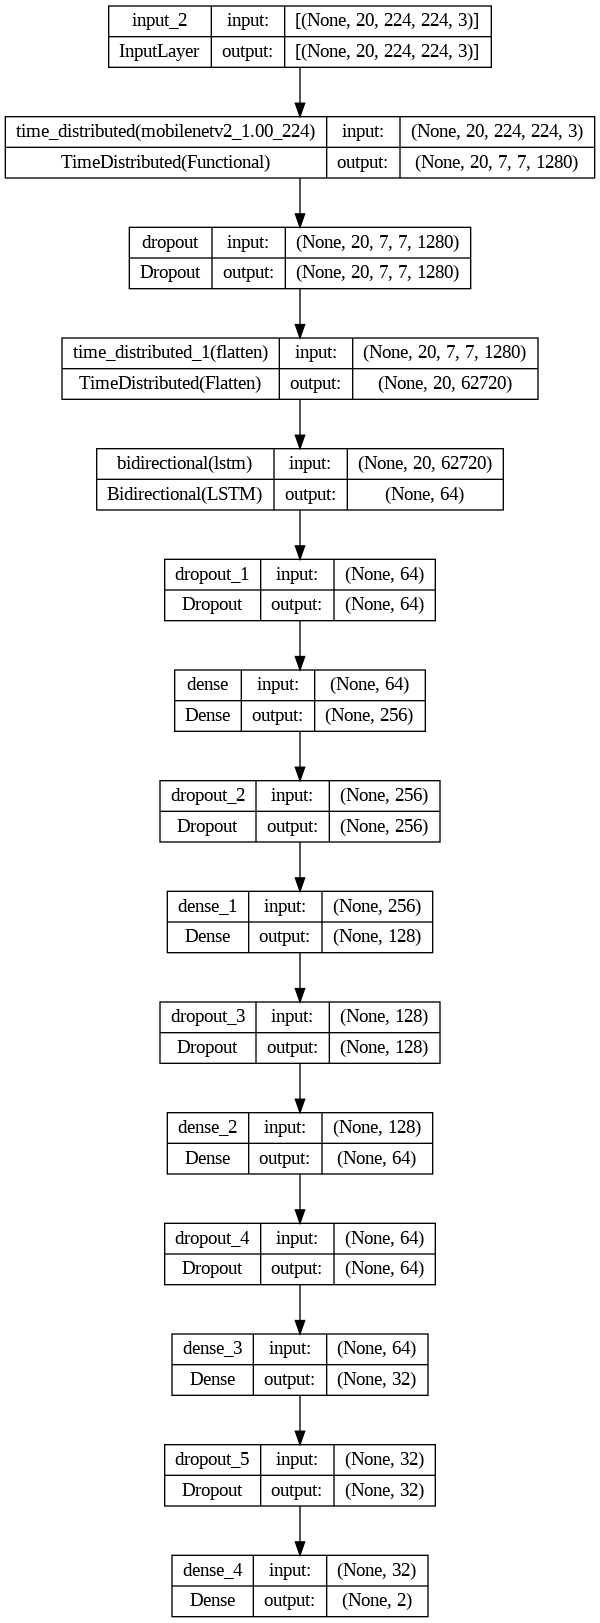

In [ ]:
# Constructing the Model
my_LSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(my_LSTM_model, to_file = 'my_LSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0005

batch_size = 8
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)


In [ ]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy',
                                        patience = 5, restore_best_weights=True)

# Create checkpoint for model
# Change name for model

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.8,
                                                  patience=3,
                                                  min_lr=0.00001,
                                                  verbose=1)
callbacks = [lr_callback, early_stopping_callback, reduce_lr]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape labels_train if necessary (assuming it has shape (4,))
labels_train = labels_train.reshape((-1, 1))

# Fit and transform labels_train
labels_train_encoded = encoder.fit_transform(labels_train)

# Verify the shape of labels_train_encoded
print("Shape of labels_train_encoded:", labels_train_encoded.shape)

Shape of labels_train_encoded: (750, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Fitting the model
my_LSTM_model_history = my_LSTM_model.fit(x = features_train, y = labels_train_encoded, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2)
# , callbacks = callbacks

Epoch 1/50
75/75 [==============================] - 27s 136ms/step - loss: 0.6957 - accuracy: 0.5217 - val_loss: 0.6927 - val_accuracy: 0.4600
Epoch 2/50
75/75 [==============================] - 5s 71ms/step - loss: 0.6770 - accuracy: 0.5900 - val_loss: 0.5978 - val_accuracy: 0.8600
Epoch 3/50
75/75 [==============================] - 5s 71ms/step - loss: 0.5281 - accuracy: 0.7783 - val_loss: 0.4729 - val_accuracy: 0.8000
Epoch 4/50
75/75 [==============================] - 5s 70ms/step - loss: 0.4045 - accuracy: 0.8450 - val_loss: 0.2673 - val_accuracy: 0.9000
Epoch 5/50
75/75 [==============================] - 5s 71ms/step - loss: 0.2930 - accuracy: 0.8983 - val_loss: 0.1890 - val_accuracy: 0.9200
Epoch 6/50
75/75 [==============================] - 5s 72ms/step - loss: 0.3034 - accuracy: 0.8833 - val_loss: 0.2105 - val_accuracy: 0.9333
Epoch 7/50
75/75 [==============================] - 5s 72ms/step - loss: 0.2751 - accuracy: 0.8917 - val_loss: 0.2356 - val_accuracy: 0.8933
Epoch 8/50


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape labels_train if necessary (assuming it has shape (4,))
labels_test = labels_test.reshape((-1, 1))

# Fit and transform labels_train
labels_test = encoder.fit_transform(labels_test)

# Verify the shape of labels_train_encoded
print("Shape of labels_train_encoded:", labels_test.shape)

Shape of labels_train_encoded: (250, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
model_evaluation_history = my_LSTM_model.evaluate(features_test, labels_test)

8/8 [==============================] - 2s 211ms/step - loss: 0.3497 - accuracy: 0.9360


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

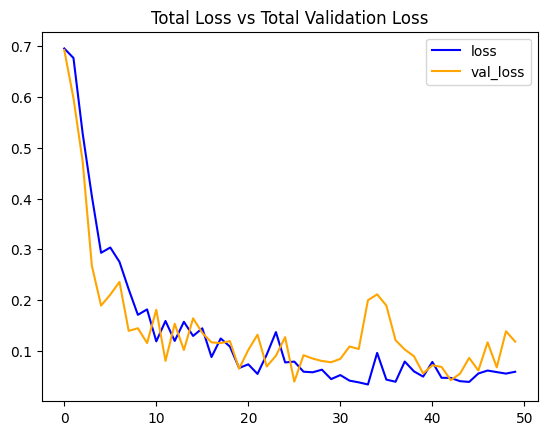

In [ ]:
plot_metric(my_LSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

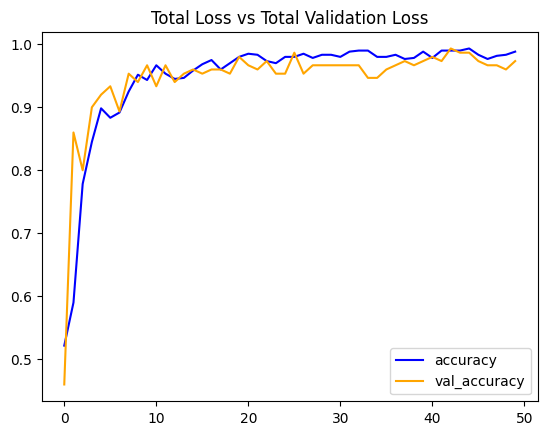

In [ ]:
plot_metric(my_LSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [ ]:
labels_predict = my_LSTM_model.predict(features_test)

8/8 [==============================] - 4s 181ms/step


In [ ]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [ ]:
labels_test_normal.shape , labels_predict.shape

((250,), (250,))

In [ ]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.936


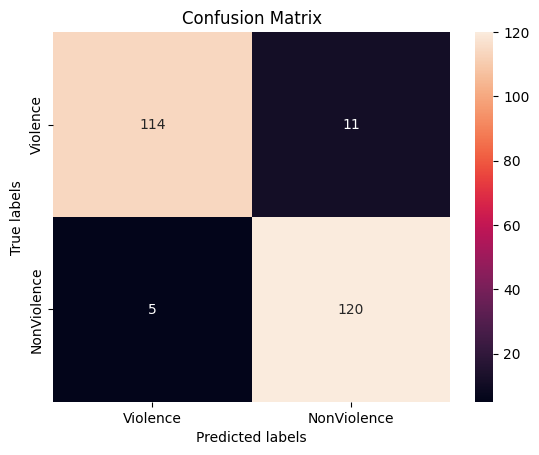

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Violence',"NonViolence"]); ax.yaxis.set_ticklabels(['Violence',"NonViolence"]);

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       125
           1       0.92      0.96      0.94       125

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250



In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
my_LSTM_model.save(model_file_name)

In [ ]:
from google.colab import files
files.download('/content/convlstm_model___Date_Time_2023_07_02__11_53_30___Loss_0.25653529167175293___Accuracy_0.9200000166893005.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>